# Background

There are several methods by which one can access IBM Quantum systems.  Each of these routines can be thought of as a software interface to quantum hardware.

## `backend.run()`

 - The original method of access to IBM Quantum systems
 
 - Access via `qiskit-ibm-provider` package
 
 - Can be viewed as an open-source, vendor agnostic device driver
 
 - Provides direct access to sampling data from device with no pre- or post-processing
 
 - Ideal for users wanting to characterize / benchmark quantum systems, or looking to develop software such as error mitigation techniques
 
 - Requires users to possess comprehensive knowledge of hardware details to be successful

## Qiskit Runtime

As quantum computing matures, and users further detached from device physics gain interest, it is important to abstract as much of the knowledge required for using `backend.run()` away from users, so that focus can be on building applications and algorithms.

The **Qiskit Runtime** is a quantum device driver designed to abstract many details away from users, and give a high-fidelity managed user experience to those who prefer a more automated execution process.  Specifically, IBM Quantum knows many of the knobs that, to first-order, give best results and can be automatically set for users.  For these features, the options and code can be pushed into a cloud execution environment.

The Qiskit Runtime provides:

   - A simple interface that abstracts away hardware details, and removes the need for boilerplate code
   
   - Accessed through the `qiskit-ibm-runtime` package
   
   - By default, does a variety of pre- and post-processing steps (including error suppression and mitigation) that aim to improve returned results
   
   - Can be viewed as a closed-source, vendor specific device driver
   
   - Ideal for users at the level of algorithms and applications
   
   - Not as flexible as `backend.run()`

The Runtime consists of a collection of "primitives"; common quantum computational routines that are executed in a dockerized cloud environment.  The two primitives available to date are:

| Primitive | What it does | Inputs | Outputs |
| --- | --- | --- | --- |
| **Sampler** | Samples circuit output distributions, possibly with error mitigation | Quantum circuits | Quasi-probability distributions |
| **Estimator** | Computes expectation values for operators and states defined by circuits, possibly with error mitigation | Quantum circuits and operators | A list of expectation values (and error estimates) |

# Imports

In [1]:
import numpy as np
from qiskit import *
from qiskit.quantum_info import hellinger_fidelity

# Operators from Qiskit
from qiskit.quantum_info import SparsePauliOp

# Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options


# Plotting tools
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

# Setup: Test circuit

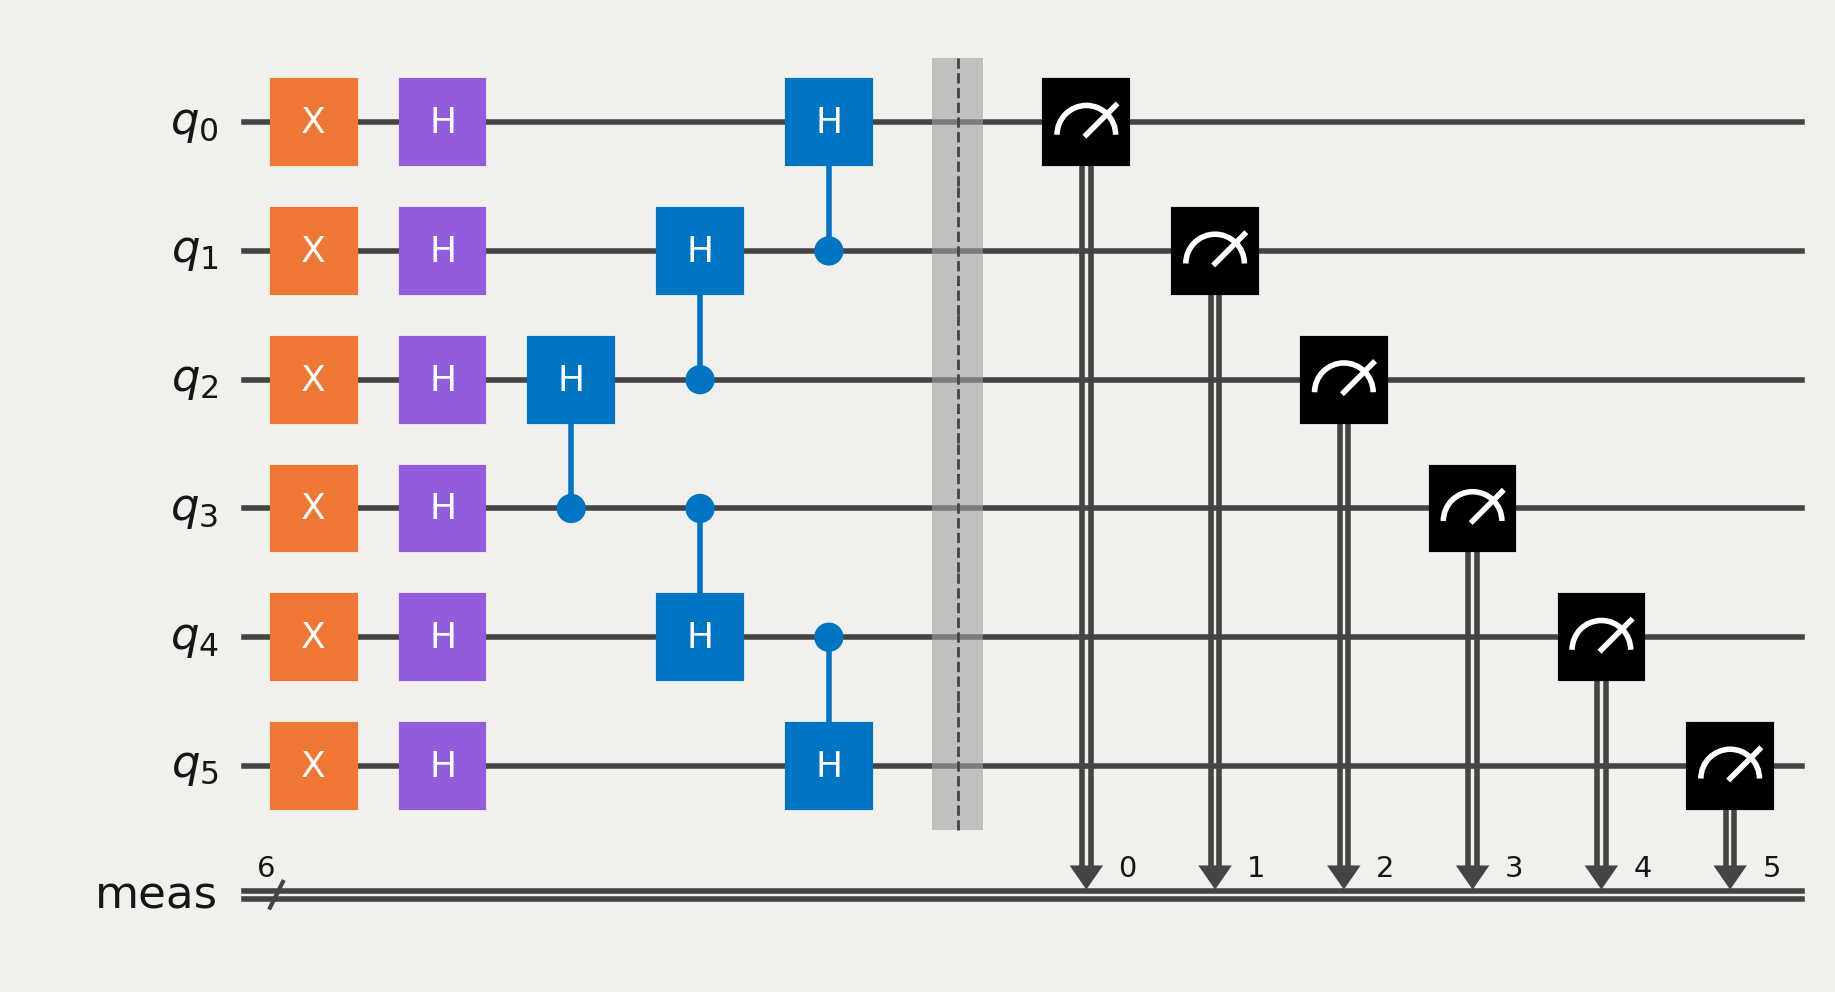

In [2]:
def cntrl_hadamard_ladder(N, measurements=False):
    qc = QuantumCircuit(N)

    qc.x(range(N))
    qc.h(range(N))

    for kk in range(N // 2, 0, -1):
        qc.ch(kk, kk - 1)
    for kk in range(N // 2, N - 1):
        qc.ch(kk, kk + 1)
    if measurements:
        qc.measure_all()
    return qc

N = 6
qc = cntrl_hadamard_ladder(N, measurements=True)
qc.draw('mpl')

# Qiskit Runtime *Sampler* Primitive

In [3]:
instance = "system-request/7-14-23-access/main"
service = QiskitRuntimeService(instance=instance)

In [4]:
service.backends();

In [5]:
service.backends(simulator=True)

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>]

In [6]:
service.jobs();

In [7]:
service.jobs(backend_name="ibmq_qasm_simulator");

In [8]:
backend = service.get_backend("ibmq_qasm_simulator")

In [9]:
sampler = Sampler(backend=backend)

In [10]:
job = sampler.run(qc)
job.job_id();

In [11]:
res = job.result()

In [12]:
res.quasi_dists

[{32: 0.01725,
  33: 0.013,
  1: 0.01675,
  0: 0.017,
  3: 0.03625,
  7: 0.0615,
  39: 0.066,
  35: 0.03525,
  49: 0.032,
  63: 0.49675,
  55: 0.12075,
  51: 0.05925,
  48: 0.02825}]

In [13]:
res.metadata

[{'shots': 4000}]

## Running inside a Session

In [14]:
def run_with_sampler_in_session(circuits, service, sampler_name, options=None):
    """Wrapper for running circuits with runtime Sampler inside a Session.
    We will be re-using this construct a number of time. Therefore, it is warpped
    insided a function for re-usability.
    """
    with Session(service=service, backend=sampler_name) as session:
        sampler = Sampler(session=session, options=options)
        job = sampler.run(circuits)
        result = job.result()

    session.close()
    
    return result

<div class="alert alert-warning">
   <div>
       <big><b>Note</b></big>
   </div>
   <br>
    It is advised to close a session with explicit `session.close()` command after "all" jobs have finished.
</div>

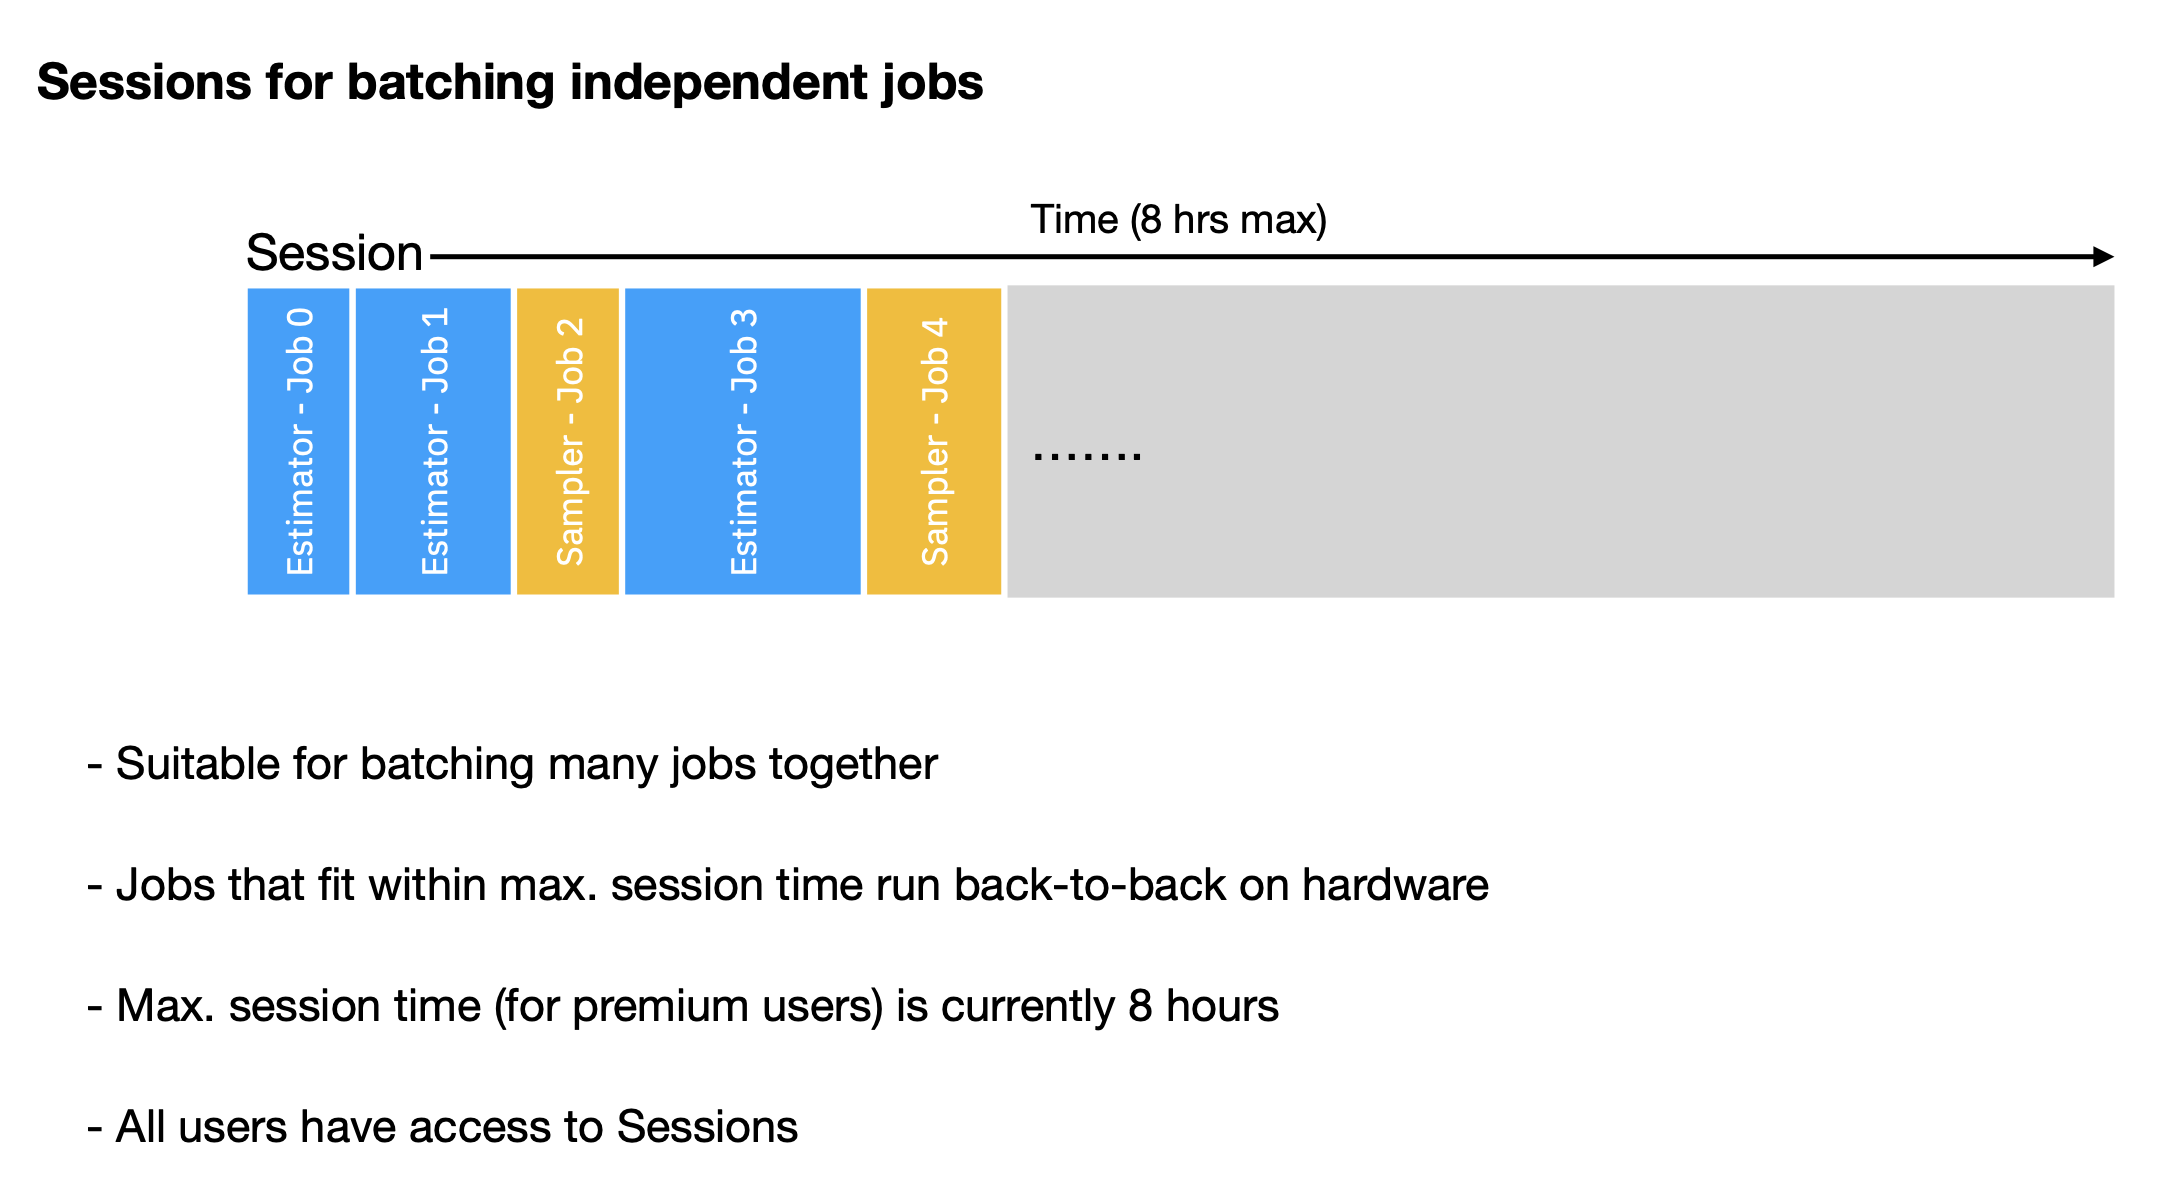

<div class="alert alert-danger">
   <div>
       <big><b>Danger</b></big>
   </div>
   <br>
    If you close a session with unfinished jobs in it, then those jobs will be canceled!
</div>

In [15]:
sampler_name = "ibmq_qasm_simulator"
res = run_with_sampler_in_session(circuits=qc, service=service, sampler_name=sampler_name)
ideal_dists = res.quasi_dists
ideal_dists[0]

{33: 0.01225,
 1: 0.014,
 49: 0.02825,
 48: 0.03025,
 51: 0.06325,
 55: 0.12275,
 63: 0.51025,
 32: 0.01675,
 35: 0.03175,
 3: 0.02675,
 0: 0.01525,
 7: 0.0625,
 39: 0.066}

Unlike the usual `Counts` returned via `backend.run()`, the quasi-distribution states are given as integers rather than bit-strings, and the values are not discrete counts. This is because, as the number of qubits grows, the size of the bit-string keys grows much larger than the equivilent integer representation.

Alternatively, one can work in bit-strings:

In [16]:
ideal_dists[0].binary_probabilities()

{'100001': 0.01225,
 '000001': 0.014,
 '110001': 0.02825,
 '110000': 0.03025,
 '110011': 0.06325,
 '110111': 0.12275,
 '111111': 0.51025,
 '100000': 0.01675,
 '100011': 0.03175,
 '000011': 0.02675,
 '000000': 0.01525,
 '000111': 0.0625,
 '100111': 0.066}

In [17]:
res.metadata

[{'shots': 4000}]

## Configuring Options

In [18]:
options = Options()
import pprint
pprint.pprint(options)

Options(optimization_level=None,
        resilience_level=None,
        max_execution_time=None,
        transpilation=TranspilationOptions(skip_transpilation=False,
                                           initial_layout=None,
                                           layout_method=None,
                                           routing_method=None,
                                           approximation_degree=None),
        resilience=ResilienceOptions(noise_amplifier='TwoQubitAmplifier',
                                     noise_factors=(1, 3, 5),
                                     extrapolator='LinearExtrapolator'),
        execution=ExecutionOptions(shots=4000, init_qubits=True),
        environment=EnvironmentOptions(log_level='WARNING',
                                       callback=None,
                                       job_tags=[]),
        simulator=SimulatorOptions(noise_model=None,
                                   seed_simulator=None,
                     

In [19]:
options.optimization_level = 0
options.resilience_level = 0
options.execution.shots = 10000

In [20]:
res = run_with_sampler_in_session(
    circuits=qc,
    service=service,
    sampler_name=sampler_name,
    options=options
)
ideal_dists = res.quasi_dists
ideal_dists[0]

{35: 0.0329,
 1: 0.0161,
 55: 0.1251,
 33: 0.0179,
 63: 0.4991,
 48: 0.0317,
 51: 0.0636,
 3: 0.0327,
 39: 0.0599,
 0: 0.0166,
 7: 0.0607,
 49: 0.0283,
 32: 0.0154}

In [21]:
res.metadata

[{'shots': 10000}]

## Running on real backend with Sampler

In [22]:
sampler_name = "ibm_peekskill"
res_hw = run_with_sampler_in_session(
    circuits=qc,
    service=service,
    sampler_name=sampler_name,
    options=options
)
hw_dists = res_hw.quasi_dists
fidelity = hellinger_fidelity(ideal_dists[0], hw_dists[0])
fidelity

0.7242072430745119

<div class="alert alert-warning">
   <div>
       <big><b>Things to be careful of</b></big>
   </div>
   <br>
    With the generalization to quasi-probability distributions some things that work for canonical probability distributions do not work when negative values are encountered.  One such example is computing the fidelity between two distributions.  For example, if the quasi-probability distribution has negative values then the fidelity calculation will fail due to the use of sqrts.
</div>

## Noisy Simulation with Runtime Sampler

In [23]:
# fetch a noise model from backend
from qiskit_aer.noise import NoiseModel

backend = service.get_backend("ibm_peekskill")
noise_model = NoiseModel.from_backend(backend)

In [24]:
options.simulator.noise_model = noise_model
options.simulator.basis_gates = backend.operation_names
options.simulator.coupling_map = backend.coupling_map

In [25]:
sampler_name = "ibmq_qasm_simulator"

In [26]:
res_noisy = run_with_sampler_in_session(
    circuits=qc,
    service=service,
    sampler_name=sampler_name,
    options=options
)
noisy_dists = res_noisy.quasi_dists
fidelity = hellinger_fidelity(ideal_dists[0], noisy_dists[0])
fidelity

0.8024001668953176

In [27]:
options.simulator.set_backend(backend) # avaialble from qiskit-ibm-runtime 0.11.2

In [28]:
res_noisy = run_with_sampler_in_session(
    circuits=qc,
    service=service,
    sampler_name=sampler_name,
    options=options
)
noisy_dists = res_noisy.quasi_dists
fidelity = hellinger_fidelity(ideal_dists[0], noisy_dists[0])
fidelity

0.8065789183306369

## Error Suppression and mitigation with Sampler

Playing with `optimization_level` and `resilience_level` in `Options()`, we can activate different error suppression and mitigation methods in runtime.

| Optimization Level | Sampler and Estimator |
| --- | --- |
| **Level 0** | No optimization and  no error suppression |
| **Level 1** | Light optimization and Dynamical Decoupling | 
| **Level 2** | Medium optimization and Dynamical Decoupling | 
| **Level 3** | Heavy optimization and Dynamical Decoupling | 

| Resilience Levels | Sampler | Estimator |
| --- | --- | --- |
| **Level 0** | No mitigation | No mitigation | 
| **Level 1** (default) | M3 readout correction | TREX readout correction | 
| **Level 2** | No mitigation | ZNE (no readout correction) | 
| **Level 3** | No mitigation | PEC | 

In [29]:
options.optimizationa_level = 3
options.resilience_level = 1

In [32]:
res_mitigated = run_with_sampler_in_session(
    circuits=qc,
    service=service,
    sampler_name=sampler_name,
    options=options
)
mitigated_dists = res_mitigated.quasi_dists
fidelity = hellinger_fidelity(ideal_dists[0], mitigated_dists[0])
fidelity

0.5614615544758632